In [1]:
from addit.dit import rundit
import jax.numpy as jnp
import numpy as np
from addit.ncf import inc3D

In [2]:
def voigt_kernel(k, beta,gammaL):
    """Fourier Kernel of the Voigt Profile
    
    Args:
        k: conjugated of wavenumber
        beta: Gaussian standard deviation
        gammaL: Lorentian Half Width
        
    Returns:
        kernel (N_x,N_beta,N_gammaL)
    
    Note:
        Conversions to the (full) width, wG and wL are as follows: 
        wG=2*sqrt(2*ln2) beta
        wL=2*gamma
    
    """
    val=(jnp.pi*beta[None,:,None]*k[:,None,None])**2 + jnp.pi*gammaL[None,None,:]*k[:,None,None]
    return jnp.exp(-2.0*val)
    

In [74]:
def rundit(S,nu_lines,beta,gammaL,nu_grid,beta_grid,gammaL_grid):
    """run DIT
    
    """
    Ng_nu=len(nu_grid)
    Ng_beta=len(beta_grid)
    Ng_gammaL=len(gammaL_grid)
    
    log_beta=jnp.log(beta)
    log_gammaL=jnp.log(gammaL)
    
    log_beta_grid = jnp.log(beta_grid)
    log_gammaL_grid = jnp.log(gammaL_grid)
    
    dnu = (nu_grid[-1]-nu_grid[0])/(Ng_nu-1)
    k = jnp.fft.rfftfreq(2*Ng_nu,dnu)
    val=inc3D(S,nu_lines,log_beta,log_gammaL,nu_grid,log_beta_grid,log_gammaL_grid)
    valbuf=jnp.vstack([val,jnp.zeros_like(val)])
    fftval = jnp.fft.rfft(valbuf,axis=0)
    vk=voigt_kernel(k, beta_grid,gammaL_grid)
    fftvalsum = jnp.sum(fftval*vk,axis=(1,2))
    #F0=jnp.fft.irfft(fftvalsum)[:Ng_nu]
    F0=jnp.fft.irfft(fftvalsum)[:Ng_nu]
    return F0

In [2]:
N=10000
Ng_nu=40000
Ng_beta=7
Ng_gammaL=8

nus=np.linspace(1900.0,2300.0,Ng_nu) #nu grid
beta_grid=np.logspace(-3,3,Ng_beta) #beta grid
gammaL_grid=np.logspace(-3,3,Ng_gammaL)#gammaL grid
S=np.logspace(0.0,2.0,N)
S[0:10]=1000.0

nu_lines=np.random.rand(N)*(nus[-1]-nus[0]-100.0)+nus[0]+50.0
beta=np.random.rand(N)*1.0
gammaL=np.random.rand(N)*1.0

In [3]:
F0=rundit(S,nu_lines,beta,gammaL,nus,beta_grid,gammaL_grid)

In [4]:
import matplotlib.pyplot as plt

In [5]:
from exojax.spec import xsection
xsv=xsection(nus,nu_lines,beta,gammaL,S)

100%|██████████| 102/102 [00:01<00:00, 10.07it/s]


In [6]:
nus[1]-nus[0]

0.010000250006214628

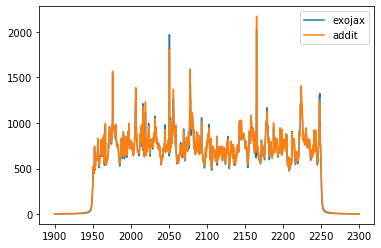

In [12]:
fig=plt.figure()
plt.plot(nus,xsv,label="exojax")
plt.plot(nus,F0,label="addit")
plt.legend()
#plt.xlim(2020,2030)

(2020, 2030)

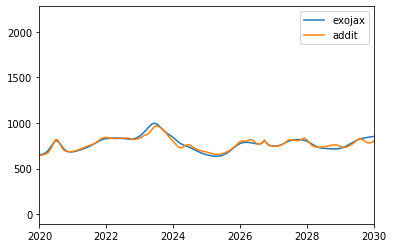

In [13]:
fig=plt.figure()
plt.plot(nus,xsv,label="exojax")
plt.plot(nus,F0,label="addit")
plt.legend()
plt.xlim(2020,2030)